In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import seaborn as sns
import math

In [ ]:
f = '/content/drive/MyDrive/Stock_Data.csv'
data = pd.read_csv(f, index_col=0, parse_dates=True)


In [ ]:
def returns_df(data):
	
  web = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
  source = pd.read_html(web)
  spx_tickers = source[0][['Symbol','GICS Sector']]

  stocks = [s for s in spx_tickers['Symbol']]
  df = pd.DataFrame()

  for stock in stocks:
    df[stock] = data['Close'][data['symbol'] == stock]
    df[stock] = df[stock].astype('float64')
    df[stock] = np.log(df[stock]) - np.log(df[stock].shift(1))

  df = df.dropna(axis=1, how='all')
  stocks = df.columns.values.tolist()

  return df, stocks


In [ ]:
def returns_df_year(df, year):
  
  start_date = str(year) + '-01-01'
  end_date = str(year+1) + '-01-01'
  df = df[(df.index >= start_date) & (df.index < end_date)]
  df = df.dropna(axis=1, how='all')

  stocks = df.columns.values.tolist()

  return df, stocks


In [ ]:
def sectors():
  
  web = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
  source = pd.read_html(web)
  spx_tickers = source[0][['Symbol','GICS Sector']]

  sectors = [sect for sect in spx_tickers['GICS Sector'].unique()]
  colours = ['red', 'blue', 'green', 'yellow', 'magenta', 'orange', 'aqua', 'purple', 'violet', 'brown', 'grey']
  sector_colours = {}
  
  for i in range(len(sectors)):
    sector_colours[sectors[i]] = colours[i]

  return spx_tickers, sector_colours

In [ ]:
def returns_analysis(data):
  '''
  Plot distribution of price returns
  '''
  plt.figure(figsize=(5,4))
  plt.hist(data['Close'].pct_change(1), bins=80, cumulative=True, histtype='step')
  # plt.hist(np.log(data['Close']), bins=100)
  plt.title(data['symbol'][0] + ': Distribution of daily returns')
  plt.xlabel('1 day return')
  plt.ylabel('frequency')
  plt.show()

In [ ]:

def volatility_analysis(data):
  '''
  Plot of 12 month price volatility 
  '''
  vol = np.log(data['Close']).rolling(250).std()
  avg_vol = np.mean(vol)

  plt.figure(figsize=(8,4))
  plt.plot(vol)
  plt.hlines(y=avg_vol, xmin=min(data.index), xmax=max(data.index), linestyles='dashed', colors='red')

  plt.title(data['symbol'][0] + ': Trailing 12mth Volatility')
  plt.xlabel('date')
  plt.ylabel('stdev of price')
  plt.show()

In [ ]:
def mean(X):
  m = 0.0
  for i in X:
    m += i
  
  return m/len(X)


In [ ]:
def covariance(X, Y):
  c = 0.0
  for i in range(len(X)):
    c += ((X[i]-mean(X)) * (Y[i]-mean(Y)))
  return c/len(X)

In [ ]:
def pearson(X, Y):
  return covariance(X,Y) / ((covariance(X,X)**0.5) * (covariance(Y,Y)**0.5))

In [ ]:
def corr_coeff(X, Y):

  X, Y = X.dropna(), Y.dropna()
  X_returns, Y_returns = [], []

  intersecting_dates = (X.index).intersection(Y.index)
  for date in intersecting_dates:
    X_returns.append(float(X.loc[date]))
    Y_returns.append(float(Y.loc[date]))

  return pearson(X_returns, Y_returns)


In [ ]:
def corr_heatmap(data):

  df = data[0]

  plt.figure(figsize=(10,10))
  sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=False)
  plt.show()

In [ ]:
def build_network(returns_data):
	
  corr_network = nx.Graph()

  stocks = returns_data[1]
  returns_data = returns_data[0]
  num_stocks = len(stocks)
  n = 1

  for i in range(num_stocks-1):
    for j in range(i+1, num_stocks):
      a = stocks[i] 
      b = stocks[j]
      #print(f'{n}) working on {a} and {b}')
      try:
        distance = math.sqrt(2*(1.0 - corr_coeff(returns_data[a], returns_data[b])))
        corr_network.add_edge(a, b, weight=distance)
      except Exception as e:
        print(e, a, b)
      #print('edge added!')
      n += 1

  print('Complete!')
  print(f'no of nodes: {corr_network.number_of_nodes()}')
  print(f'no of edges: {corr_network.number_of_edges()}')

  return corr_network


In [ ]:
def draw_network(corr_network):

  plt.figure(figsize=(8,8))
  nx.draw(corr_network, with_labels=True)

In [ ]:
def mst(corr_network):
  # Minimum Spanning Tree (Prims Algorithm)

  seed = 'MMM'
  nodes = []
  edges = []

  nodes.append(seed)

  while len(nodes) < corr_network.number_of_nodes():
    min_weight = 1000000.0
    for node in nodes:
      for neighbour in corr_network.neighbors(node):
        if not neighbour in nodes:
          if corr_network[node][neighbour]['weight'] < min_weight:
            min_weight = corr_network[node][neighbour]['weight']
            min_weight_edge = (node, neighbour)
            neighbour_ext = neighbour
    edges.append(min_weight_edge)
    nodes.append(neighbour_ext)


  tree = nx.Graph()
  tree.add_edges_from(edges)

  sector_lookup = sectors()[0]
  colour_lookup = sectors()[1]

  plt.figure(figsize=(15,15))
  pos = graphviz_layout(tree, prog='neato')
  nx.draw_networkx_edges(tree, pos, width=2, edge_color='black', alpha=0.5, style='solid')
  nx.draw_networkx_labels(tree, pos)

  for node in tree.nodes():
    col = colour_lookup[sector_lookup[sector_lookup['Symbol']==node]['GICS Sector'].iloc[0]]
    nx.draw_networkx_nodes(tree, pos, [node], node_size=600, node_color=col, alpha=0.5, label=node)
  
  markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in colour_lookup.values()]
  plt.legend(markers, colour_lookup.keys(), numpoints=1)

  #savefig('/content/drive/MyDrive/tree.png', dpi=600)

In [ ]:
sector_lookup = sectors()[0]
colour_lookup = sectors()[1]

colour_lookup

{'Communication Services': 'yellow',
 'Consumer Discretionary': 'magenta',
 'Consumer Staples': 'brown',
 'Energy': 'grey',
 'Financials': 'aqua',
 'Health Care': 'blue',
 'Industrials': 'red',
 'Information Technology': 'green',
 'Materials': 'purple',
 'Real Estate': 'violet',
 'Utilities': 'orange'}

In [ ]:
full_df = returns_df(data)[0]

In [ ]:
df2008 = returns_df_year(full_df, 2008)
df2008[0].shape

(253, 367)

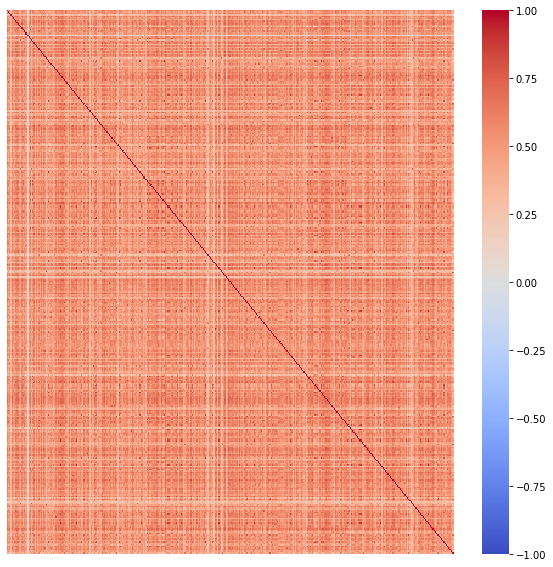

In [ ]:
# 2008 correlation
corr_heatmap(df2008)

In [ ]:
network2008 = build_network(df2008)

Complete!
no of nodes: 367
no of edges: 67161


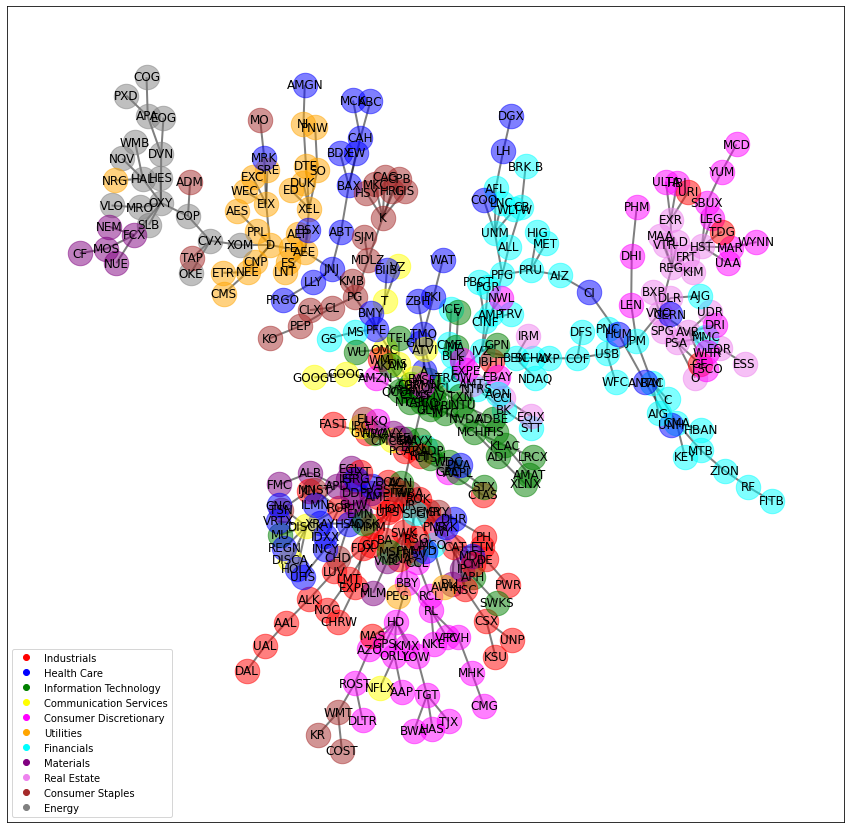

In [ ]:
mst(network2008)

In [ ]:
df2016 = returns_df_year(full_df, 2016)
df2016[0].shape

(252, 396)

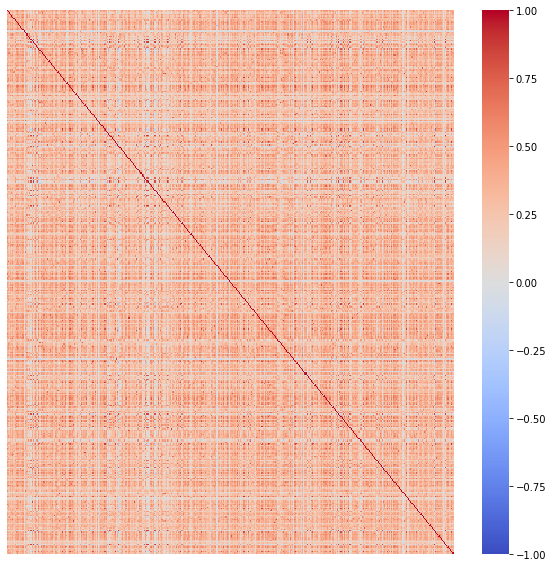

In [ ]:
# 2016 correlation
corr_heatmap(df2016)

In [ ]:
network2016 = build_network(df2016)

Complete!
no of nodes: 396
no of edges: 78210


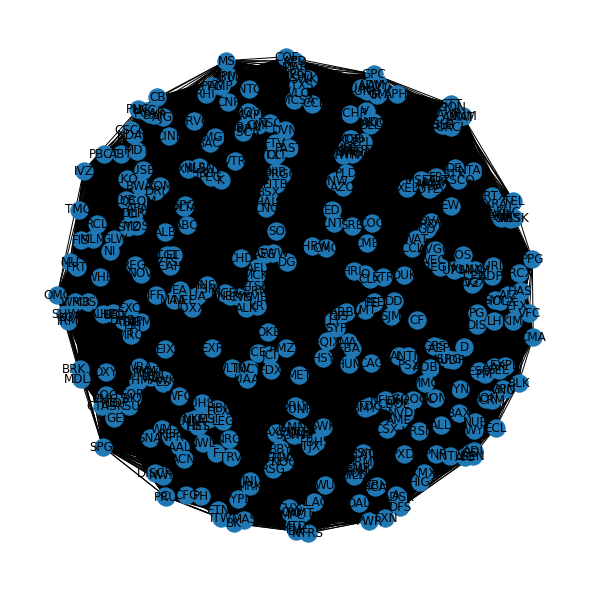

In [ ]:
#draw_network(network)


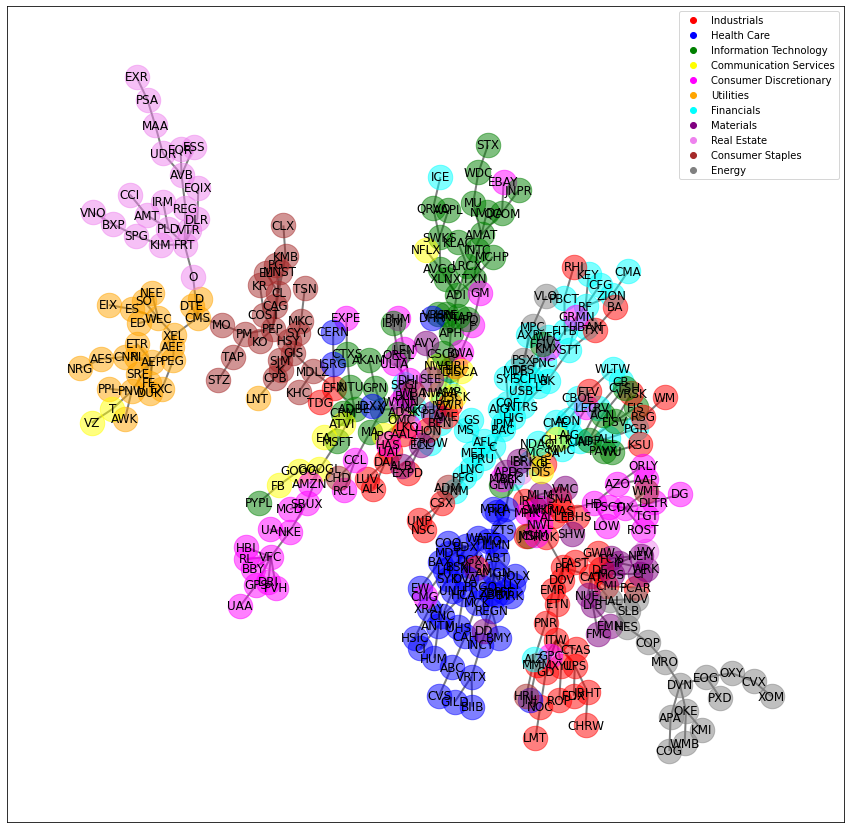

In [ ]:
mst(network2016)